# Some Data Processing Tools

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1)
})

from matplotlib.ticker import ScalarFormatter

## File paths 

In [2]:
folder_path = os.path.join("..","Fall2024Data")
flash_data_raw = os.path.join(folder_path, "ASCEND_DATA_2024_11_25_19_13_57.csv")
data2 = os.path.join(folder_path, "DATA2.CSV")
data3 = os.path.join(folder_path, "DATA3.CSV")
data4 = os.path.join(folder_path, "DATA4.CSV")
geiger_data = os.path.join(folder_path, "RadiaCode Log.txt")
geiger_spectrum_xml = os.path.join(folder_path, "RadiaCode_ Spectrum.xml")

aprs_data_csv = os.path.join(folder_path, "aprsfi_KA7NSR-9_data.csv")

# create directory for processed files:
temp_folder = "F24Processed"
os.makedirs(temp_folder, exist_ok=True)

# folder to store graphs
graph_folder = "Graphs"
os.makedirs(graph_folder, exist_ok=True)

In [3]:
def parseHeader(header_field):
    header_field = int(header_field, 16)
    full_no_fail_header = [
      "Header,",
      "Millis,",

      "PCFTime, ", 
      # "DS3231Time,DS3231TempC,",
      "BMETemp(C),BMEPress(hPa),BMEHum(%),BMEGas(KOhms),BMEAlt(m),",    
      # "GeigerSensor(CPS),", 
      "INACurr(mA),INAVolt(mV),INAPow(mW),",                   
      "LSM9DS1 AccX, LSM9DS1 AccY, LSM9DS1 AccZ, LSM9DS1 GyroX, LSM9DS1 GyroY, LSM9DS1 GyroZ, LSM9DS1 MagX, LSM9DS1 MagY, LSM9DS1 MagZ,", 
      # "SHTHum(%), SHTTemp(C),",
      "PicoTemp(C),",
      #"WindADC,TempADC,", 
      "SGPTVOC(ppb),SGPeCO2(ppm),SGPTVOCBase(ppb),SGPeCO2Base(ppb),SGPH2,SGPEtha,",
      "BME280RelHum %,BME280Pres Pa,BME280Alt m,BME280TempC,DewPointC,",  
      "ENSAQI,ENSTVOC ppb,ENSECO2 ppm,",
      "UVA2(nm),UVB2(nm),UVC2(nm),",
      "UVA0(nm),UVB0(nm),UVC0(nm),",
      "ICM AccX,ICM AccY,ICM AccZ,ICM GyroX,ICM GyroY,ICM GyroZ,ICM MagX,ICM MagY,ICM MagZ,ICM TempC,",
      "MTK_Date,MTK_Lat,MTKLong,MTKSpeed,MTKAngle,MTKAlt,MTKSats,",
      " "  # final space for matching fsw?
    ]
    header_bin = bin(header_field)[2:]
    header_bin = header_bin[header_bin.find("1"):] # trim to first 1
    header = "Receive time, "
    for i in range(len(header_bin)): # add each from full header if 1
        if header_bin[i] == "1": header += full_no_fail_header[i]
    return header

## Getting Data

In [4]:
# get flash data
flash_data = os.path.join(temp_folder, "flash_data_header.csv")
with open(flash_data_raw, "r") as fin, open(flash_data, "w") as fout:
    finlist = list(fin)
    fout.write(parseHeader(finlist[0].split(",")[1]) + "\n")
    for line in finlist:
        if(line.split(",")[1] == " 3f82" and line.split(",")[3].find("2005") != -1):
            break
        if(line.split(",")[1] == " 3f82"):
            fout.write(line)

In [5]:
custom_na = pd._libs.parsers.STR_NA_VALUES
custom_na.add("-")
flash_df = pd.read_csv(flash_data, skipinitialspace=True, na_values=custom_na)

flash_df["BMEGas(KOhms)"] = [i / 1000.0 for i in flash_df["BMEGas(KOhms)"]]
flash_df["Minutes(millis)"] = [i / 1000 / 60 for i in flash_df["Millis"]]
flash_df["LSM Accel Mag"] = [math.sqrt(x**2 + y**2 + z**2)/8 for x,y,z in zip(flash_df["LSM9DS1 AccX"], flash_df["LSM9DS1 AccY"], flash_df["LSM9DS1 AccZ"])]
flash_df["ICM Accel Mag"] = [math.sqrt(x**2 + y**2 + z**2)/8 for x,y,z in zip(flash_df["ICM AccX"], flash_df["ICM AccY"], flash_df["ICM AccZ"])]
flash_df["BMEGas Adj"] = [(flash_df["BMEGas(KOhms)"][i] * abs(25 / flash_df["BMETemp(C)"][i]) * (flash_df["BMEHum(%)"][i] / 50)) for i in range(len(flash_df["BMEGas(KOhms)"]))]

print(list(flash_df.columns))

['Receive time', 'Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', 'ICM GyroY', 'ICM GyroZ', 'ICM MagX', 'ICM MagY', 'ICM MagZ', 'ICM TempC', 'Unnamed: 32', 'Minutes(millis)', 'LSM Accel Mag', 'ICM Accel Mag', 'BMEGas Adj']


## General Functions
The idea is to have an array of functions that can be applied to a plot to add information to it

### Finding keypoints for shading 

In [6]:
# based on altitude, stamped by Minutes(millis) and Pressure
shaders = [None,None,None,None,None,None,None,]
altitude_m_col = "BMEAlt(m)"
# launch
initial_alt = flash_df[altitude_m_col][0]
print("Initial Altitude: ", initial_alt, "m")
index = 0
threshold = 10
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < initial_alt + threshold:
    index += 1 
launch_index = index
print("Launch time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[0] = ("Launch", 
                flash_df["Minutes(millis)"][index], 
                flash_df["Minutes(millis)"][index]+1,
                flash_df["BMEPress(hPa)"][index],
                flash_df["BMEPress(hPa)"][index]+50,
                "green", 1.0)

# burst 
index = flash_df[altitude_m_col].idxmax()
print("Burst time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[1] = ("Burst", 
                flash_df["Minutes(millis)"][index]-1, 
                flash_df["Minutes(millis)"][index], 
                flash_df["BMEPress(hPa)"][index]-0.5,
                flash_df["BMEPress(hPa)"][index],
                "red", 1.0)

# troposphere
troposphere_top = 12_000
index = launch_index
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < troposphere_top:
    index += 1
print("Troposphere Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[2] = ("Troposphere", 
                flash_df["Minutes(millis)"][0], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][0],
                flash_df["BMEPress(hPa)"][index],
                "skyblue", 0.15)

# tropopause
tropopause_top = 12_500
print("Tropopause Enter Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index 
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < tropopause_top:
    index += 1
print("Tropopause Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[3] = ("Tropopause", 
                flash_df["Minutes(millis)"][start_index], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "steelblue", 0.15)

# stratosphere before ozone layer
print("Stratosphere Enter Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index
ozone_bottom = 15_000
ozone_top = 35_000
while str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < ozone_bottom:
    index += 1
    
print("Stratosphere To Ozone Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[4] = ("Stratosphere", 
                flash_df["Minutes(millis)"][start_index], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "dodgerblue", 0.15)

# ozone layer
print("Ozone Enter Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index 

while index < len(flash_df[altitude_m_col])-1 and (str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] < ozone_top):
    index += 1
print("Ozone Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
shaders[5] = ("Ozone Layer", 
                flash_df["Minutes(millis)"][start_index], 
                flash_df["Minutes(millis)"][index],
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "midnightblue", 0.15)

# stratosphere after ozone layer
print("Ozone to Stratosphere Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")
start_index = index 
# index = flash_df["Minutes(millis)"].idxmax()
while index < len(flash_df[altitude_m_col])-1 and (str(flash_df[altitude_m_col][index]) == "nan" or flash_df[altitude_m_col][index] > tropopause_top):
    index += 1
print("Stratosphere Exit Time: ", flash_df["Minutes(millis)"][index], f"(alt = {flash_df[altitude_m_col][index]})")

if start_index == len(flash_df[altitude_m_col])-1: time_start = np.nan
else: time_start = flash_df["Minutes(millis)"][start_index]
if index == len(flash_df[altitude_m_col])-1: time_end = np.nan
else: time_end = flash_df["Minutes(millis)"][index]

shaders[6] = ("Stratosphere", 
                time_start, 
                time_end,
                flash_df["BMEPress(hPa)"][start_index],
                flash_df["BMEPress(hPa)"][index],
                "dodgerblue", 0.15)

print("\nFills:")
print(*shaders, sep="\n")


Initial Altitude:  532.37 m
Launch time:  17.636366666666667 (alt = 544.56)
Burst time:  81.89576666666667 (alt = 26729.37)
Troposphere Exit Time:  43.1789 (alt = 12006.17)
Tropopause Enter Time:  43.1789 (alt = 12006.17)
Tropopause Exit Time:  44.16321666666667 (alt = 12504.23)
Stratosphere Enter Time:  44.16321666666667 (alt = 12504.23)
Stratosphere To Ozone Time:  48.673300000000005 (alt = 15004.82)
Ozone Enter Time:  48.673300000000005 (alt = 15004.82)
Ozone Exit Time:  82.1829 (alt = nan)
Ozone to Stratosphere Time:  82.1829 (alt = nan)
Stratosphere Exit Time:  82.1829 (alt = nan)

Fills:
('Launch', 17.636366666666667, 18.636366666666667, 949.84, 999.84, 'green', 1.0)
('Burst', 80.89576666666667, 81.89576666666667, 7.41, 7.91, 'red', 1.0)
('Troposphere', 1.4375833333333332, 43.1789, 950.92, 192.86, 'skyblue', 0.15)
('Tropopause', 43.1789, 44.16321666666667, 192.86, 177.73, 'steelblue', 0.15)
('Stratosphere', 44.16321666666667, 48.673300000000005, 177.73, 115.61, 'dodgerblue', 0.15

### Plot with Pressure as the X-axis

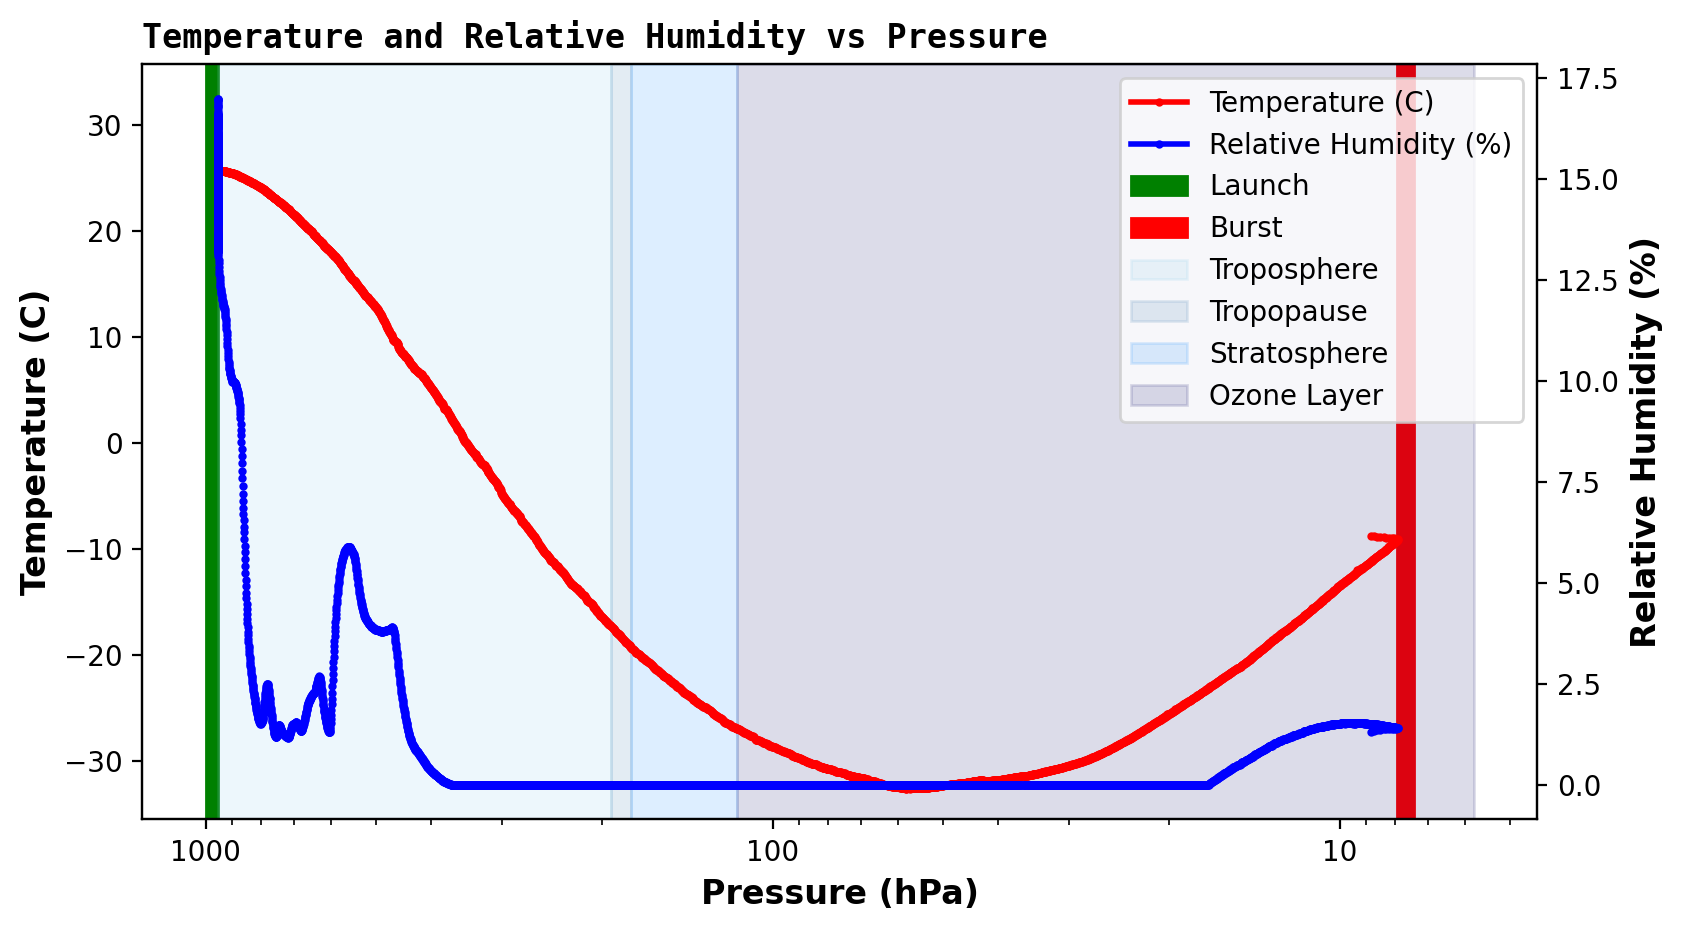

In [7]:
def pressurePlot(df, pressure_col, unit, var1, var2, fills):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    plt.title(f"{var1[1]} and {var2[1]} vs Pressure", fontsize="large", loc="left", fontweight="bold", family="monospace")
    plt.xscale("log")
    
    ax.set_xlabel(f"Pressure ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(pressure_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2, label=f"{var1[1]} ({var1[2]})")    
    
    ax2 = ax.twinx()
    ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
    line2 = plt.plot(pressure_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2, label=f"{var2[1]} ({var2[2]})")
    
    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    ax.invert_xaxis()
#     ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
    legendObj = line1 + line2
    legendLabels = [line1[0].get_label(), line2[0].get_label()]
    
    top = ax.get_ylim()[1]
    bottom = ax.get_ylim()[0]
    for fill in fills: 
        if str(fill[3]) == "nan": continue
        xstart = fill[3]
        if str(fill[4]) != "nan": xstop = fill[4]
        else: xstop = ax.get_xlim()[1]
        fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[6], label=fill[0], color=fill[5])
        legendObj += fill1
        legendLabels.append(fill1[0].get_label())
    ax.legend(legendObj, legendLabels, loc='upper right')
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_pressure.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(f'{var1[1]} and {var2[1]}'.split())}_vs_pressure.png"))
    
    plt.show()

pressurePlot(flash_df, "BMEPress(hPa)", "hPa", ("BMETemp(C)", "Temperature", "C", "red"), 
                                        ("BMEHum(%)", "Relative Humidity", "%", "blue"), shaders)



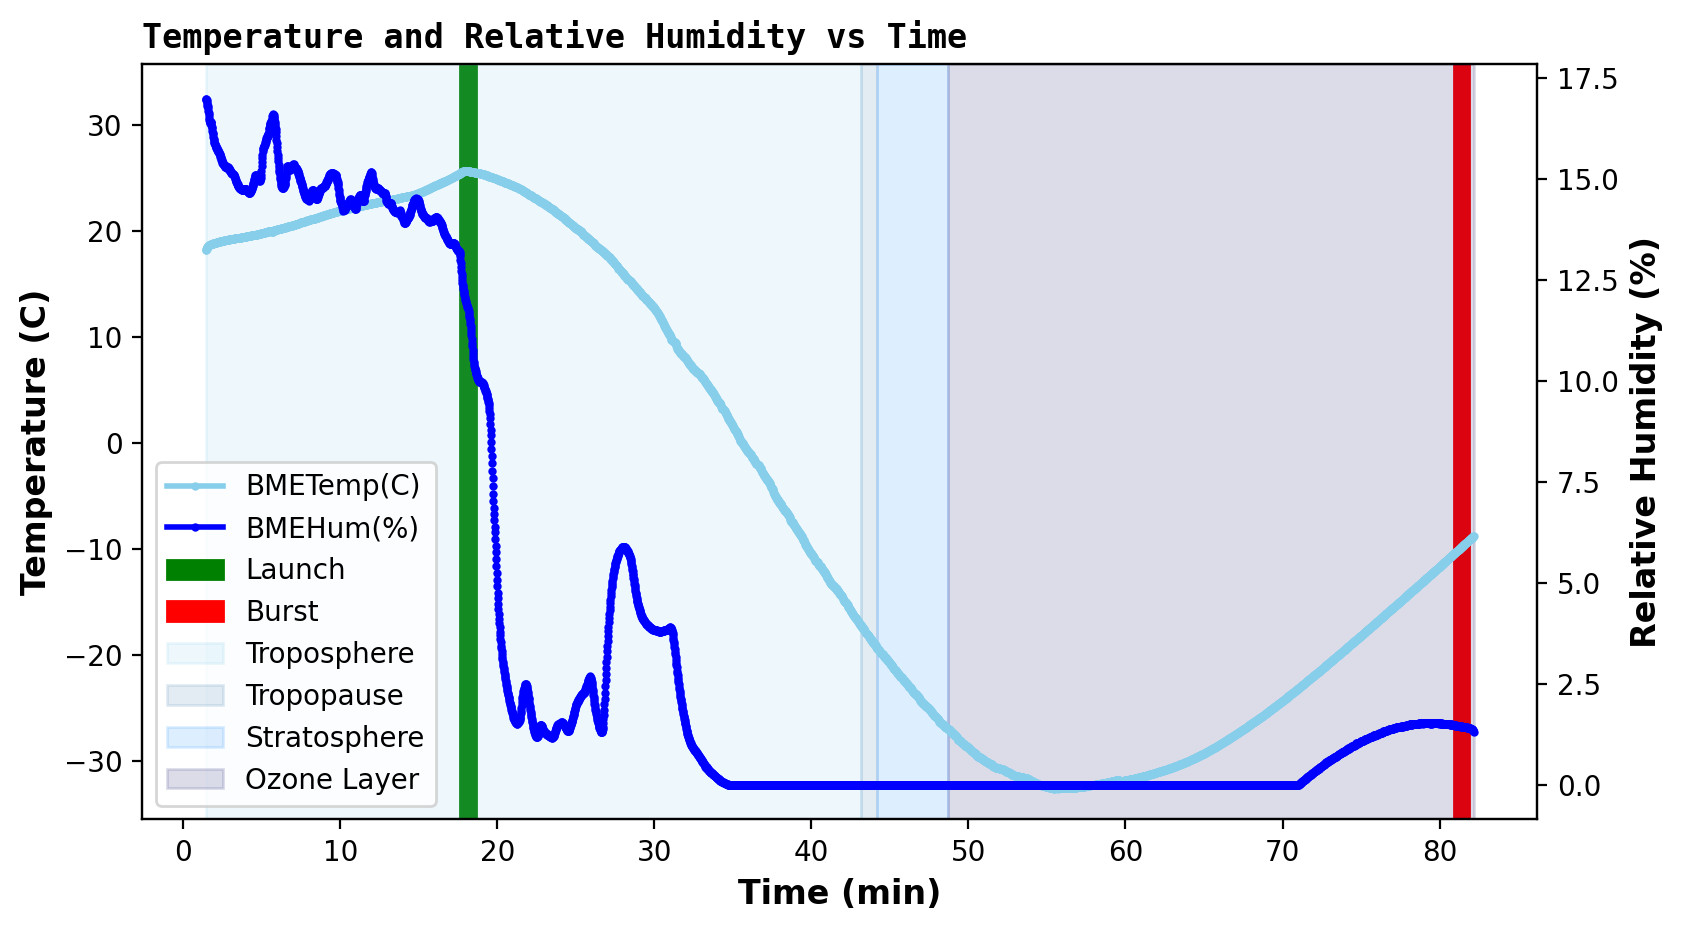

In [8]:
def timePlot(df, time_col, unit, var1, var2, fills):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    if(var2 != None):
        plot_title = f"{var1[1]} and {var2[1]} vs Time"
    else:
        plot_title = f"{var1[1]} vs Time"
    
    plt.title(plot_title, fontsize="large", loc="left", fontweight="bold", family="monospace")
    
    ax.set_xlabel(f"Time ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(time_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2)    
    
    if(var2 != None):
        ax2 = ax.twinx()
        ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
        line2 = plt.plot(time_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2)

    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    
    if(var2 != None):
        legendObj = line1 + line2
        legendLabels = [line1[0].get_label(), line2[0].get_label()]
    else:
        legendObj = line1
        legendLabels = [line1[0].get_label()]

    top = ax.get_ylim()[1]
    bottom = ax.get_ylim()[0]
    for fill in fills: 
        if str(fill[1]) == "nan": continue
        xstart = fill[1]
        if str(fill[2]) != "nan": xstop = fill[2]
        else: xstop = ax.get_xlim()[1]
        fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[6], label=fill[0], color=fill[5])
        legendObj += fill1
        legendLabels.append(fill1[0].get_label())
    ax.legend(legendObj, legendLabels)
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.split())}.svg"))
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.split())}.png"))
    
    plt.show()

timePlot(flash_df, "Minutes(millis)", "min", ("BMETemp(C)", "Temperature", "C", "skyblue"), 
                                        ("BMEHum(%)", "Relative Humidity", "%", "blue"), shaders)


In [9]:
def customPlot(df, 
               x_axis, x_col,
               left_y_axis, left_y_cols, 
               right_y_axis = None, right_y_cols = None,
               fills = None, fills_index_offset = 0, reverse_and_log = False):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    if(right_y_axis != None):
        plot_title = f"{', '.join([i[1] for i in left_y_cols])} and {', '.join([i[1] for i in right_y_cols])} vs {x_axis[0]}"
    else:
        plot_title = f"{', '.join([i[1] for i in left_y_cols])} vs {x_axis[0]}"
    plt.title(plot_title, fontsize="large", loc="left", fontweight="bold", family="monospace", x=0.05)
    
    
    ax.set_xlabel(f"{x_axis[0]} ({x_axis[1]})", fontsize="large", fontweight="bold")
    
    legendObj = []
    legendLabels = []
    
    ax.set_ylabel(f"{left_y_axis[0]} ({left_y_axis[1]})", fontsize="large", fontweight="bold")
    for col in left_y_cols:
        line = plt.plot(x_col, col[0], data=df, marker='o', markersize=2, color=col[2], linewidth=2, label=f"{col[1]} ({left_y_axis[1]})") 
        legendObj += line
        legendLabels.append(line[0].get_label())
    
    if(right_y_axis != None):
        ax2 = ax.twinx()
        
        ax2.set_ylabel(f"{right_y_axis[0]} ({right_y_axis[1]})", fontsize="large", fontweight="bold")
        for col in right_y_cols: 
            line = plt.plot(x_col, col[0], data=df, marker='o', markersize=2, color=col[2], linewidth=2, label=f"{col[1]} ({right_y_axis[1]})")
            legendObj += line
            legendLabels.append(line[0].get_label())
    
    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    if(reverse_and_log):
        plt.xscale("log")
        ax.invert_xaxis()
        ax.xaxis.set_major_formatter(ScalarFormatter())
    
    if fills != None:
        top = ax.get_ylim()[1]
        bottom = ax.get_ylim()[0]
        for fill in fills:
            if str(fill[1+fills_index_offset]) == "nan": continue
            xstart = fill[1+fills_index_offset]
            if str(fill[2+fills_index_offset]) != "nan": xstop = fill[2+fills_index_offset]
            else: xstop = ax.get_xlim()[1]
            fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[-1], label=fill[0], color=fill[-2])
            legendObj += fill1
            legendLabels.append(fill1[0].get_label())
    
    ax.legend(legendObj, legendLabels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.replace(',','').split())}.svg"), bbox_inches='tight')
    plt.savefig(os.path.join(graph_folder, f"{'_'.join(plot_title.replace(',','').split())}.png"), bbox_inches='tight')
    
    plt.show()
    

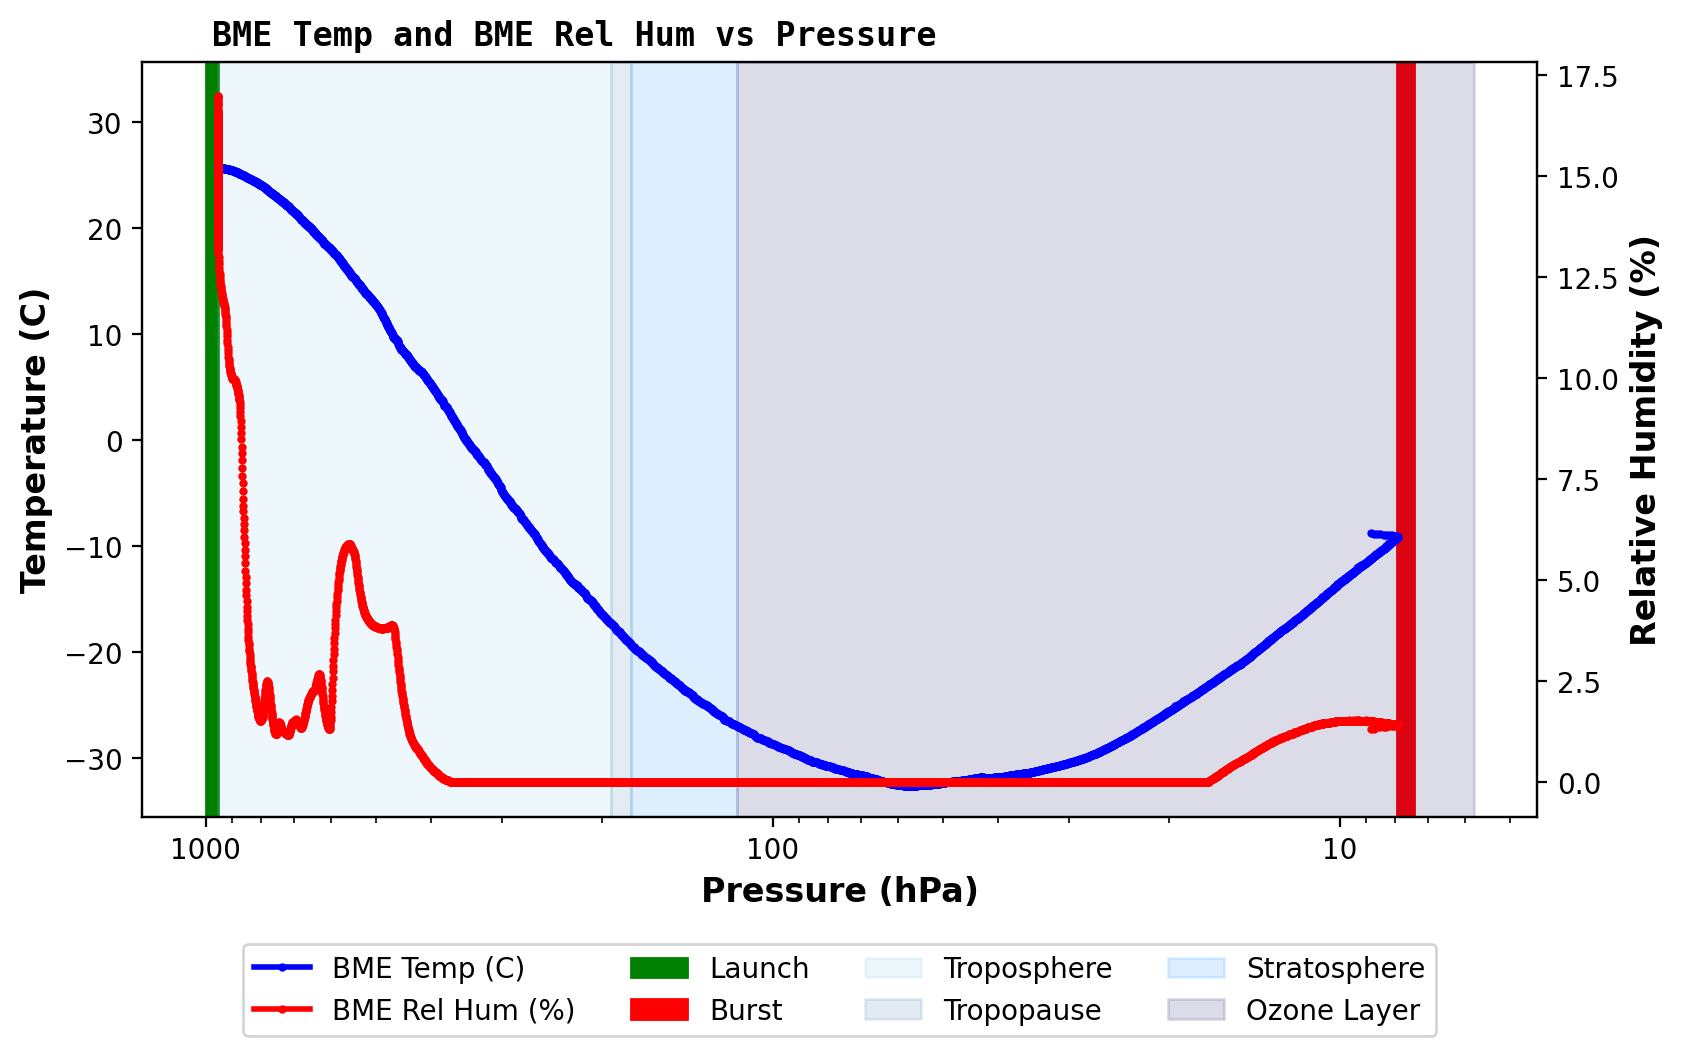

In [10]:
customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue")],
           right_y_axis = ("Relative Humidity", "%"), 
           right_y_cols = [("BMEHum(%)", "BME Rel Hum", "red")],
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)


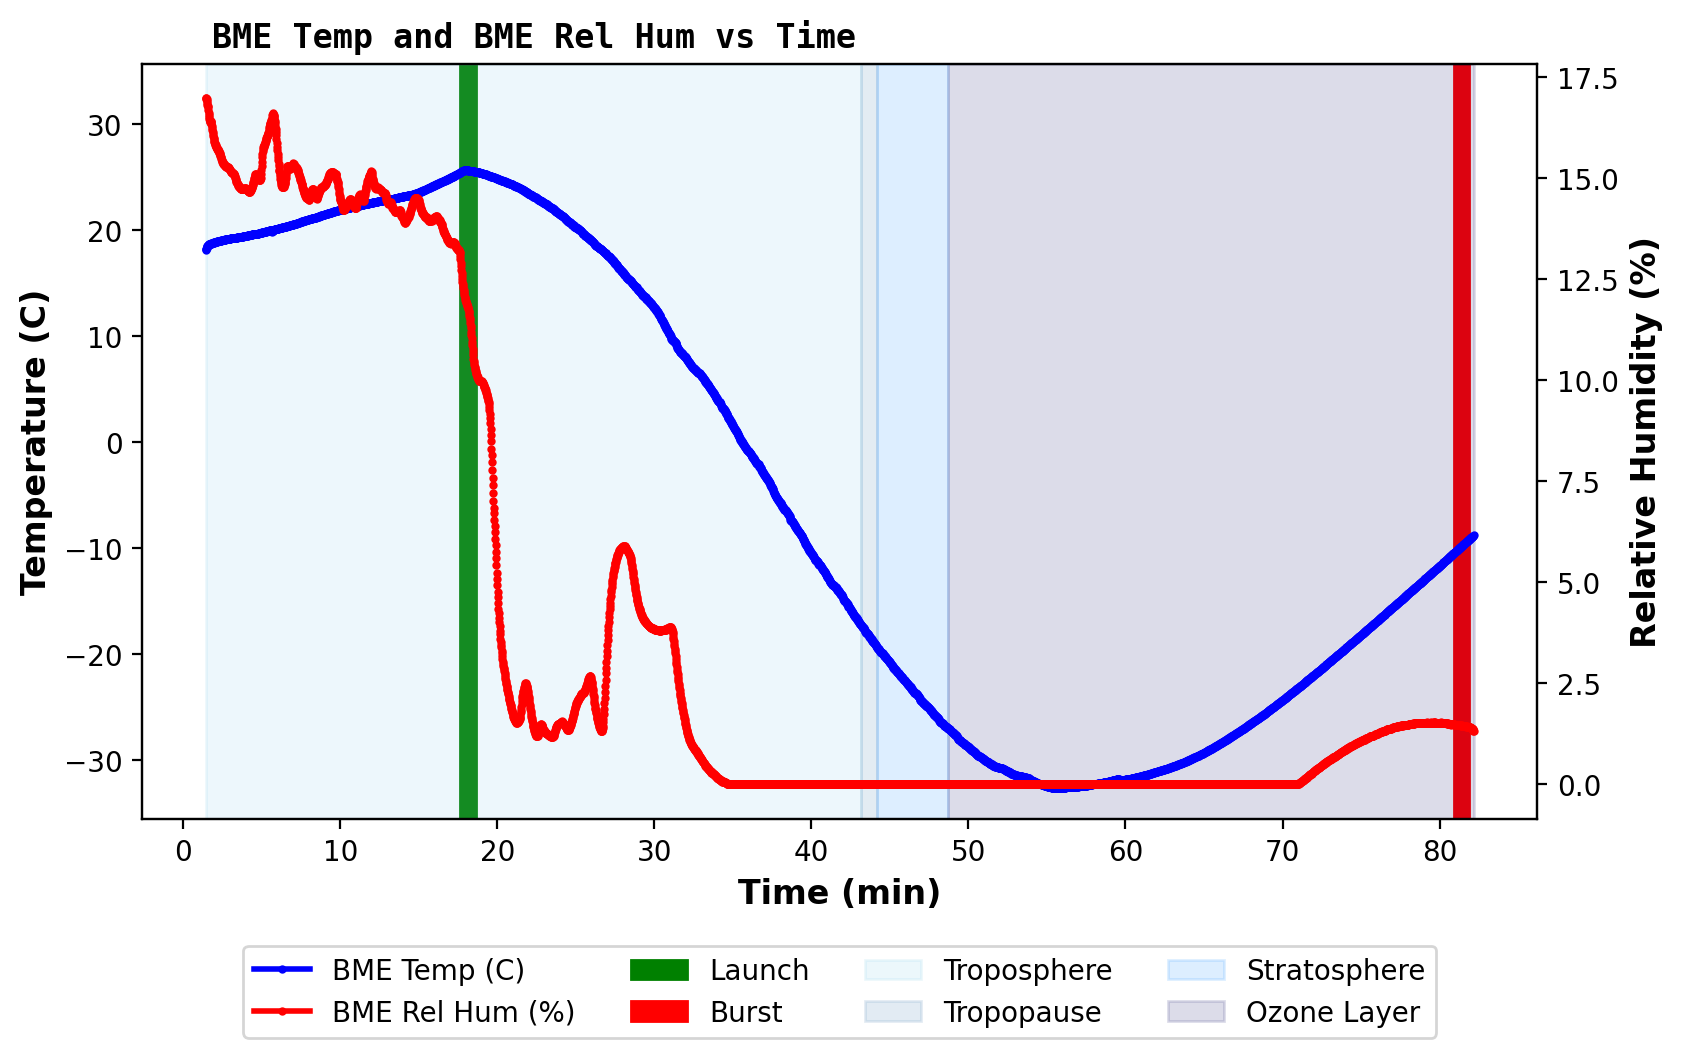

In [11]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue")],
           right_y_axis = ("Relative Humidity", "%"), 
           right_y_cols = [("BMEHum(%)", "BME Rel Hum", "red")],
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)


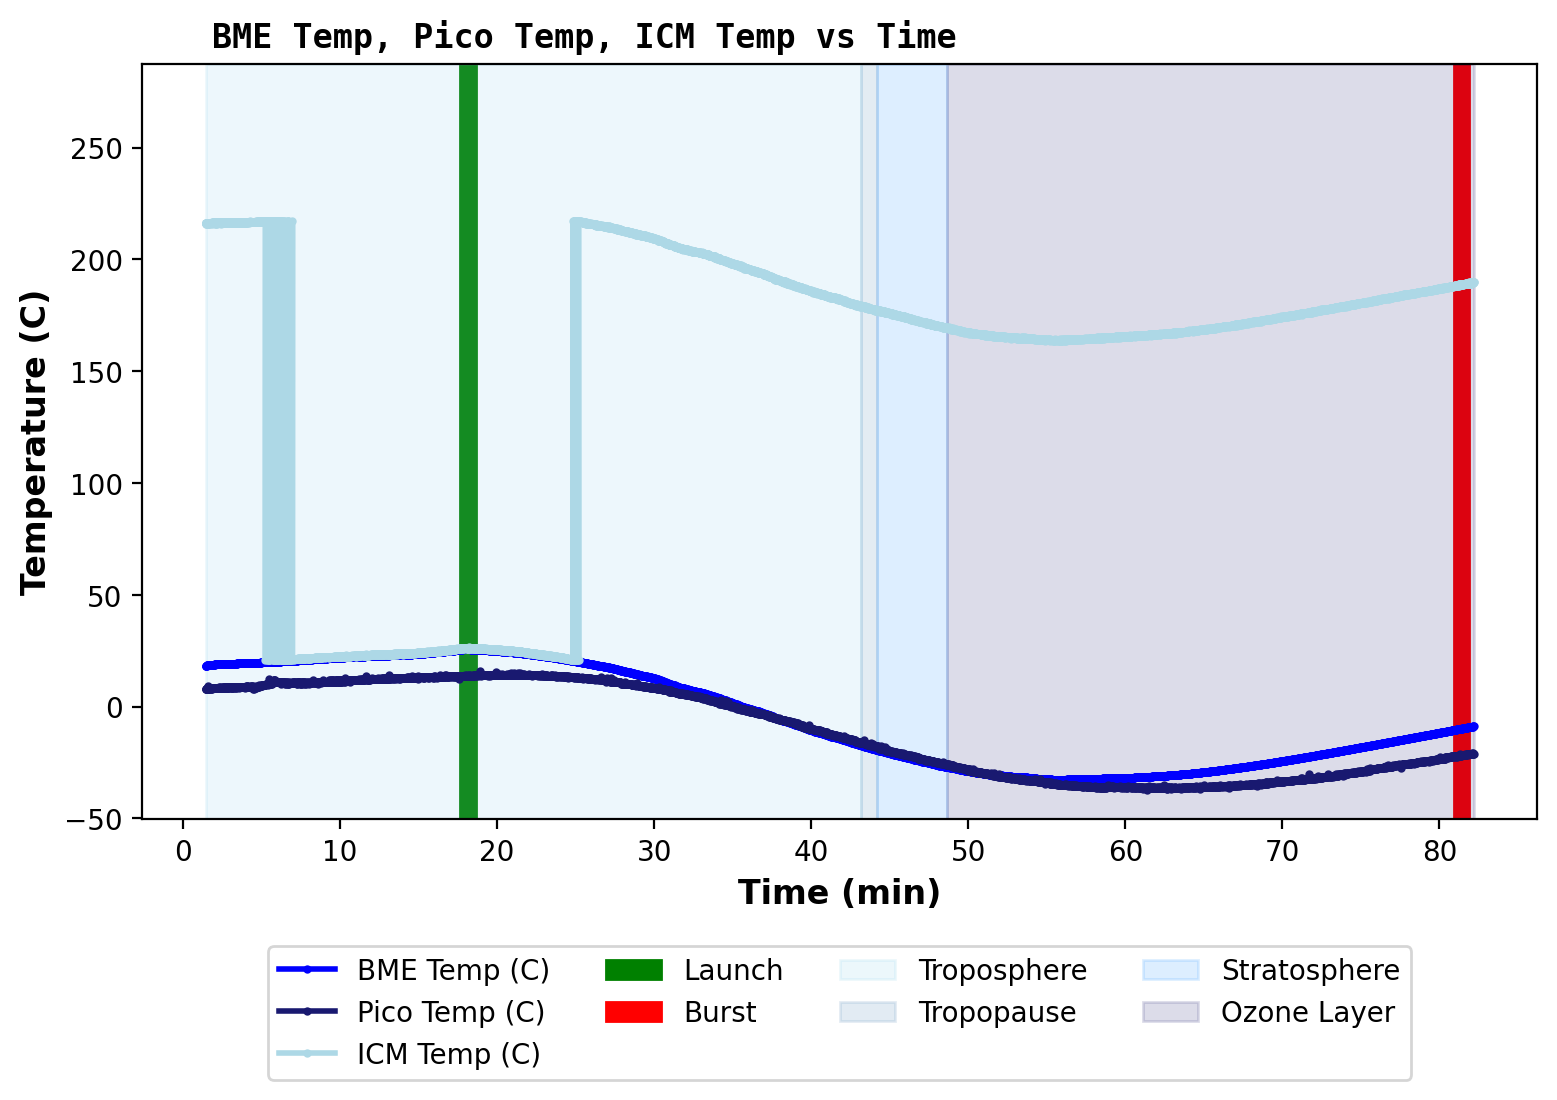

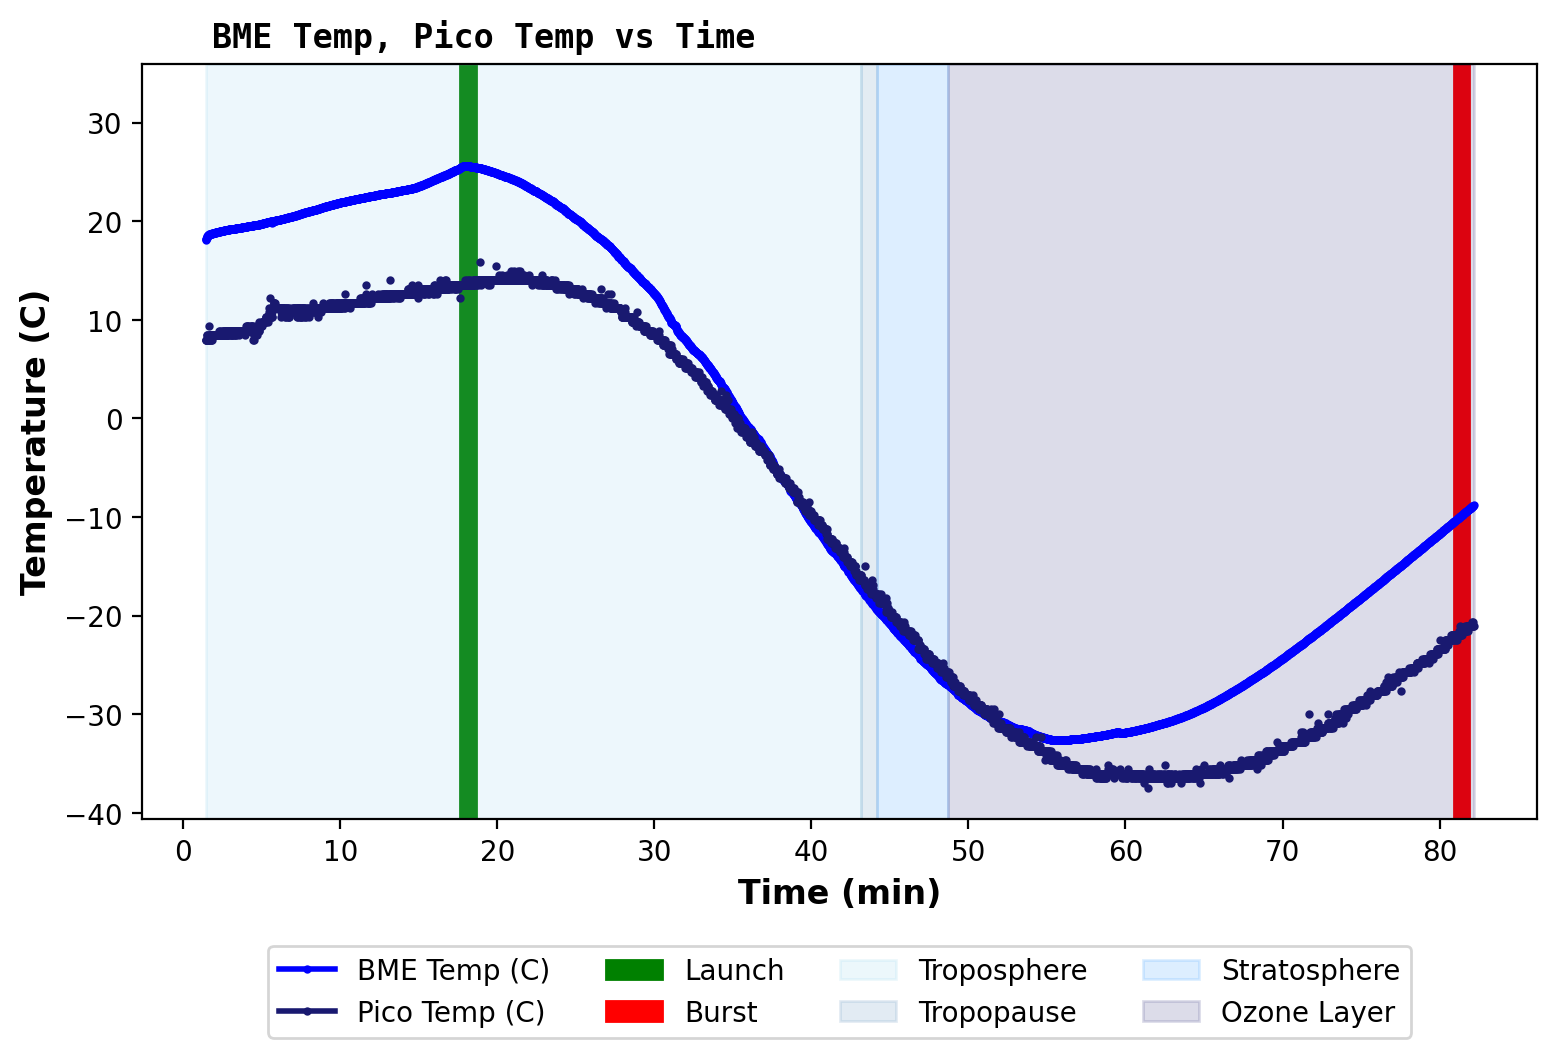

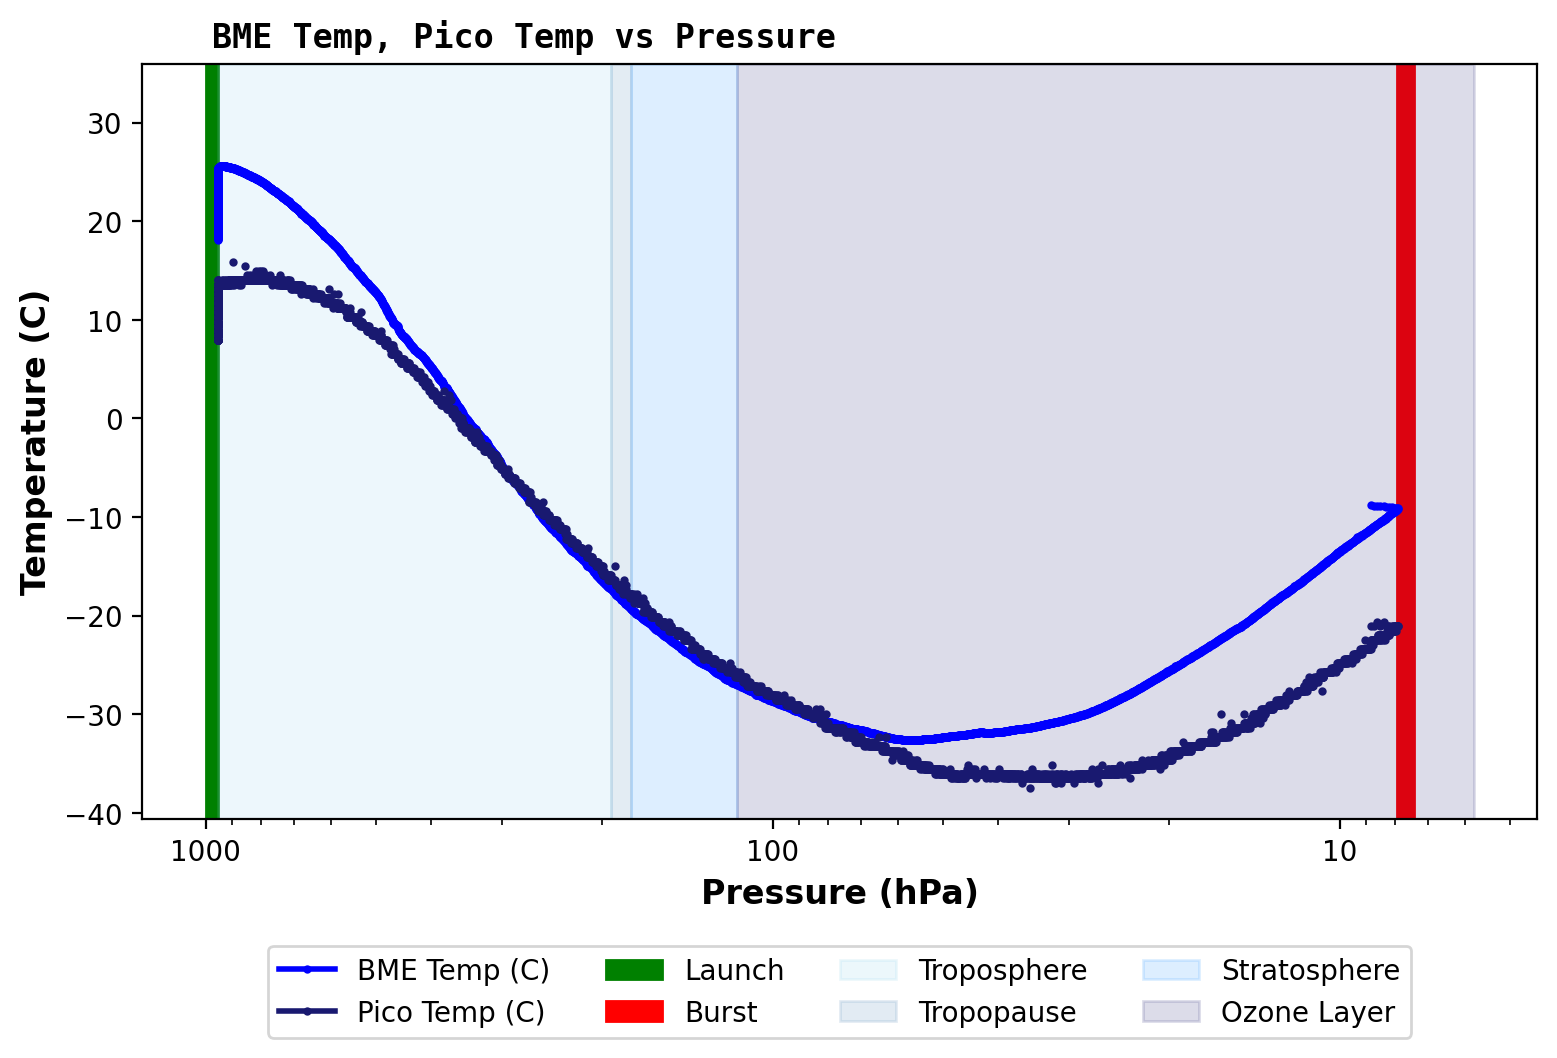

In [12]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue"), 
                          ("PicoTemp(C)", "Pico Temp", "midnightblue"),
                          ("ICM TempC", "ICM Temp", "lightblue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue"), 
                          ("PicoTemp(C)", "Pico Temp", "midnightblue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Temperature", "C"),
           left_y_cols = [("BMETemp(C)", "BME Temp", "blue"), 
                          ("PicoTemp(C)", "Pico Temp", "midnightblue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)



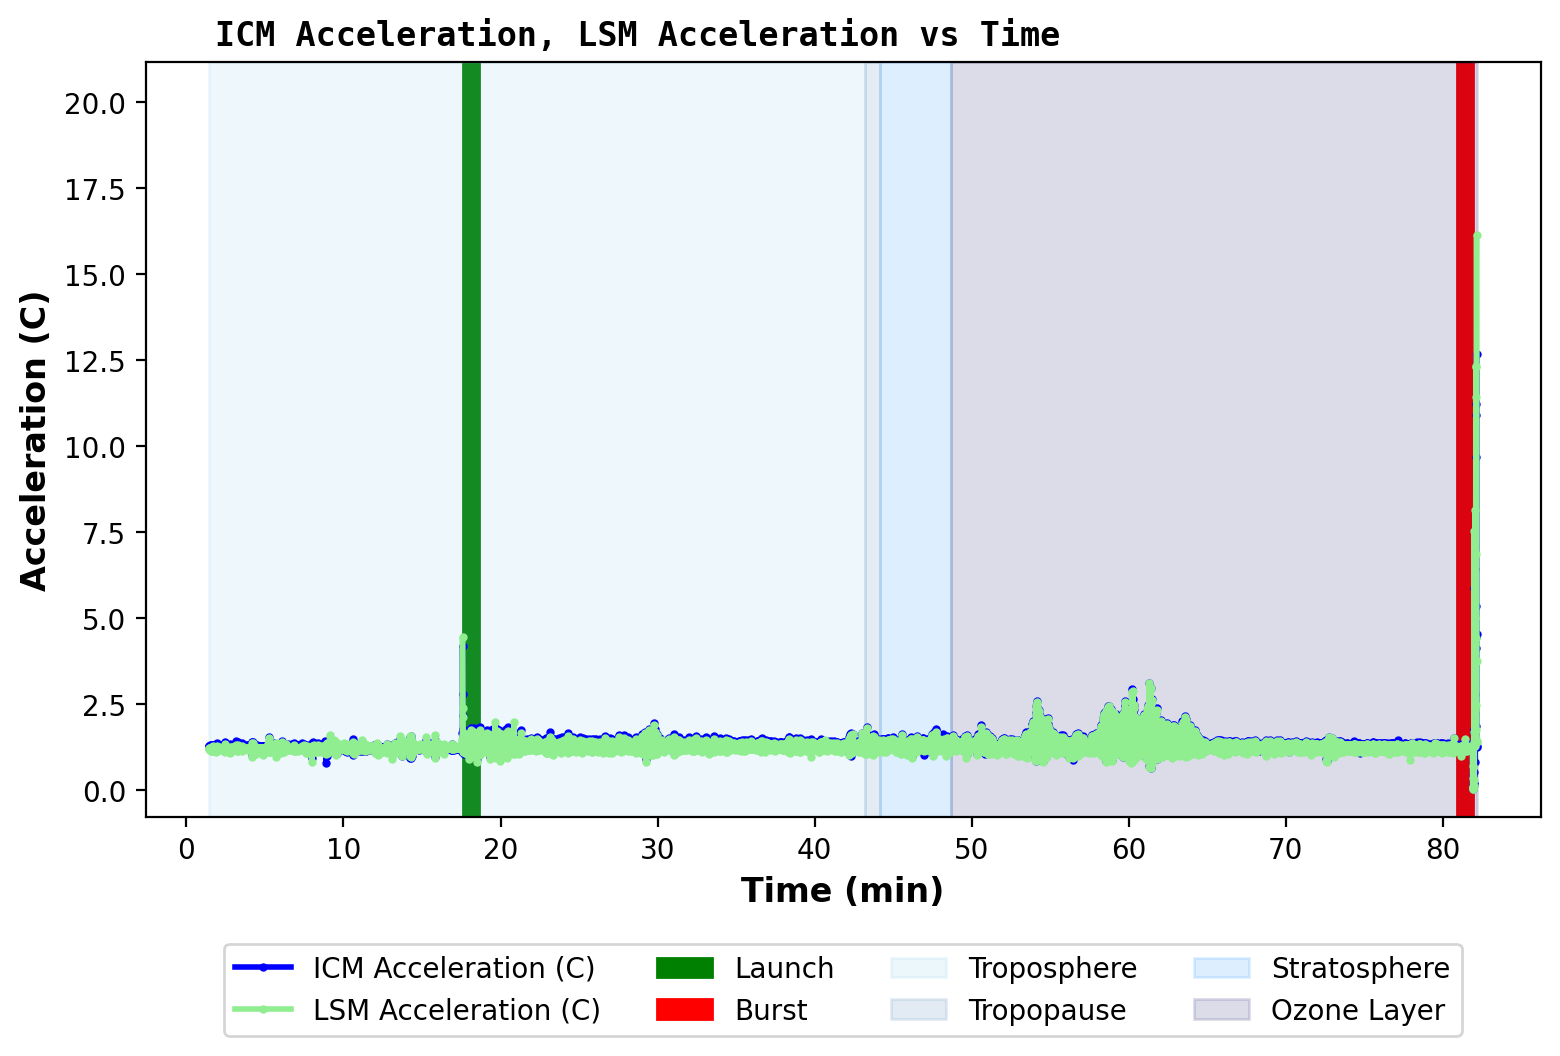

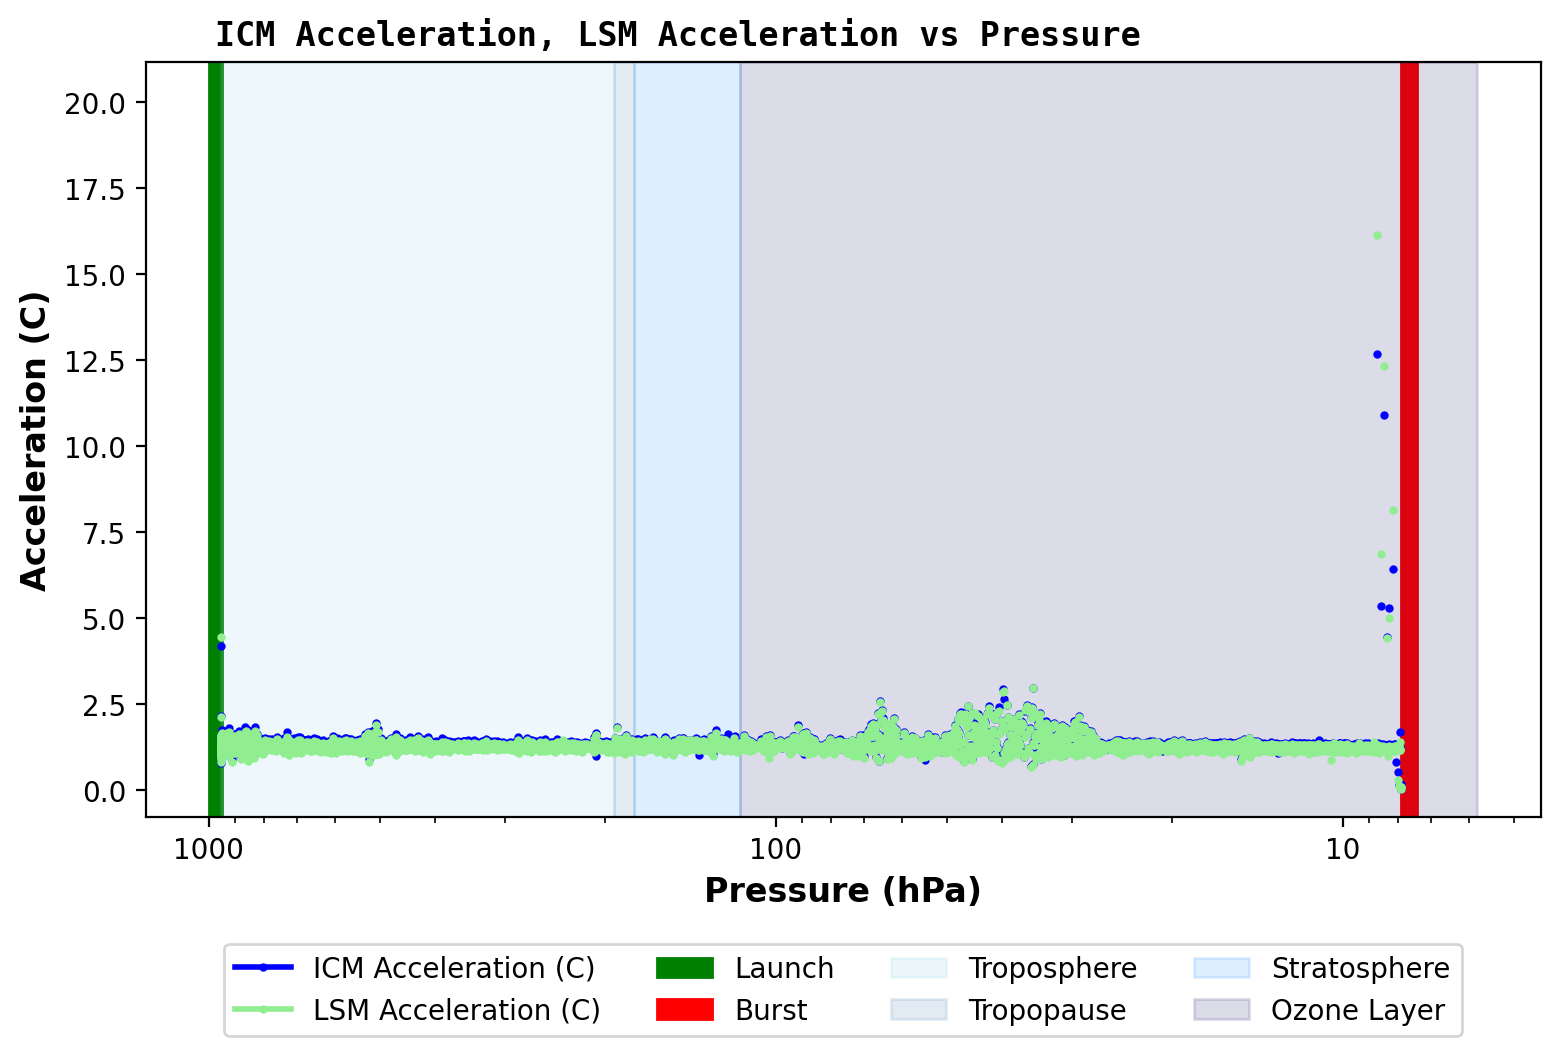

In [13]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Acceleration", "C"),
           left_y_cols = [("ICM Accel Mag", "ICM Acceleration", "blue"), 
                          ("LSM Accel Mag", "LSM Acceleration", "lightgreen")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Acceleration", "C"),
           left_y_cols = [("ICM Accel Mag", "ICM Acceleration", "blue"), 
                          ("LSM Accel Mag", "LSM Acceleration", "lightgreen")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)

 

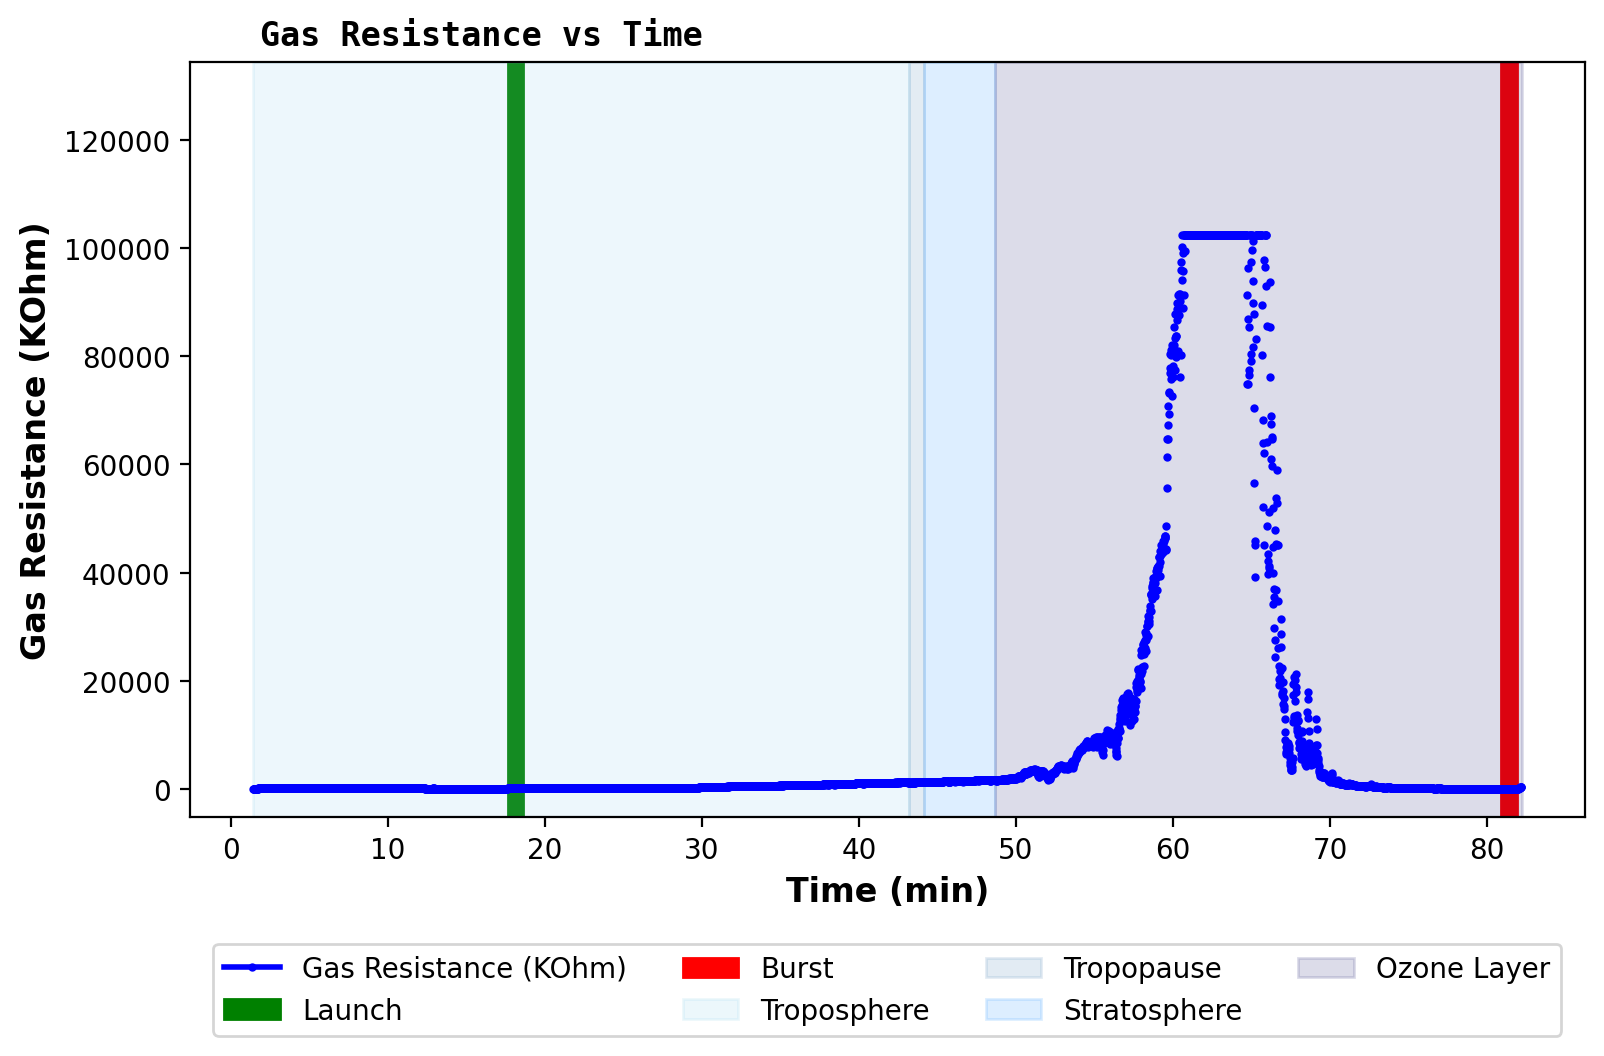

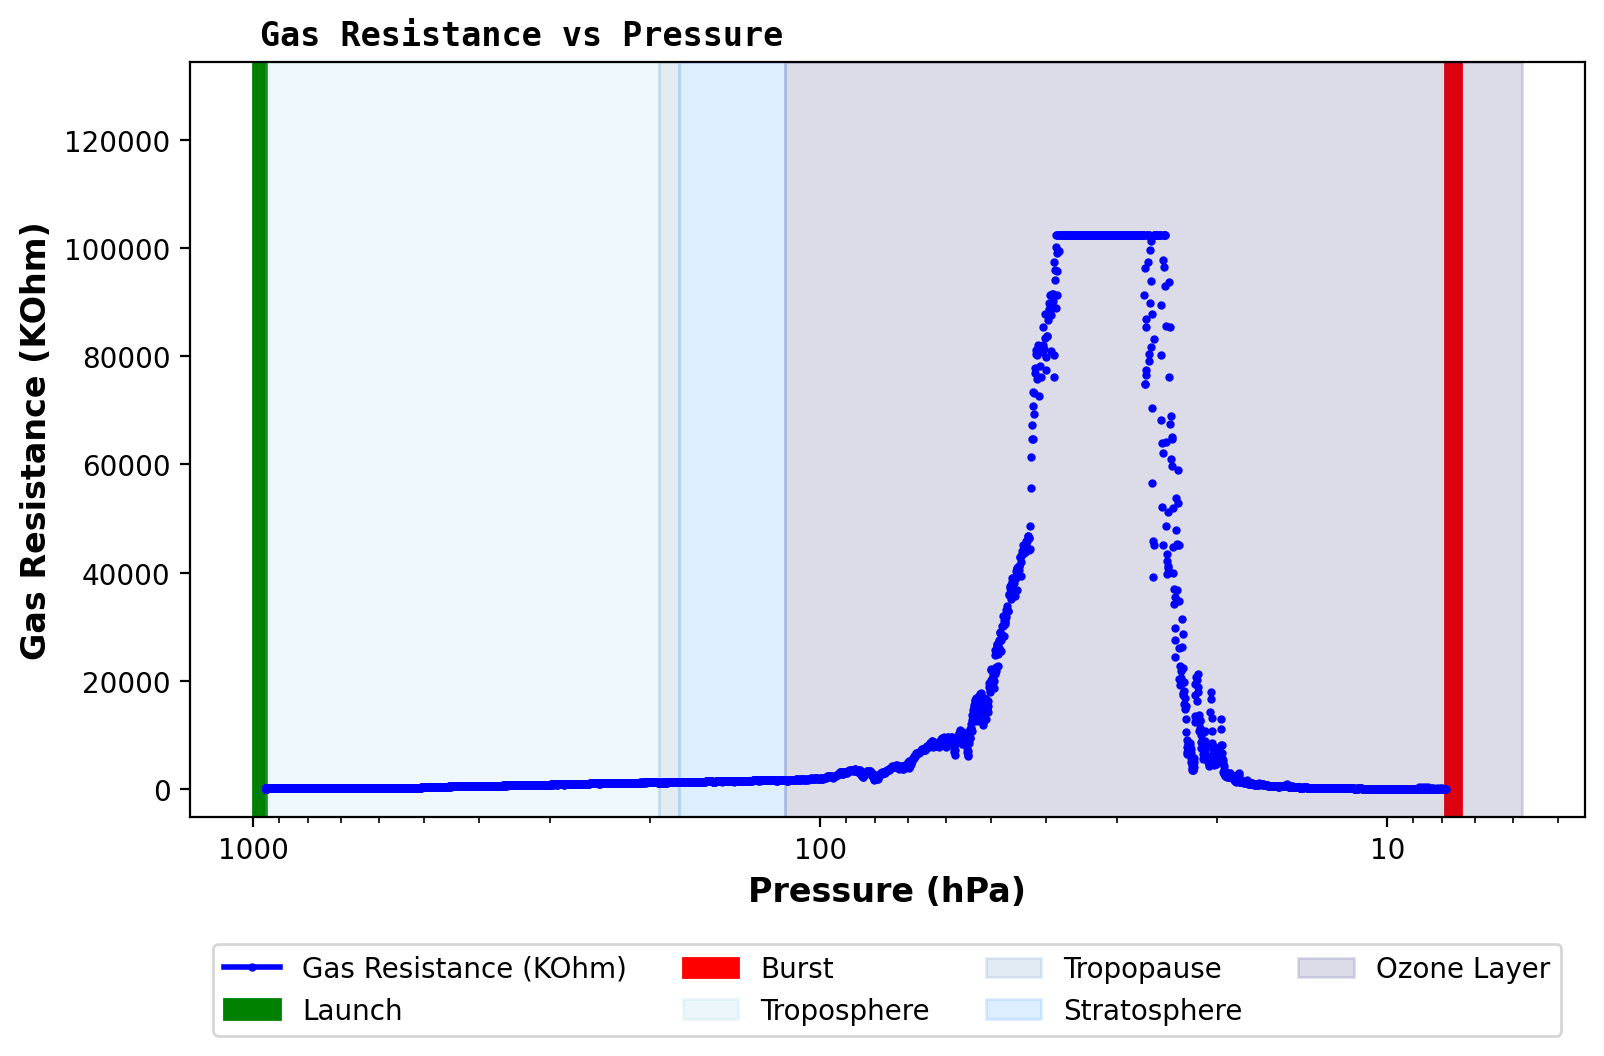

In [14]:
customPlot(df = flash_df, 
           x_axis = ("Time", "min"),
           x_col = "Minutes(millis)",
           left_y_axis = ("Gas Resistance", "KOhm"),
           left_y_cols = [("BMEGas(KOhms)", "Gas Resistance", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 0, 
           reverse_and_log = False)

customPlot(df = flash_df, 
           x_axis = ("Pressure", "hPa"),
           x_col = "BMEPress(hPa)",
           left_y_axis = ("Gas Resistance", "KOhm"),
           left_y_cols = [("BMEGas(KOhms)", "Gas Resistance", "blue")],
           right_y_axis = None, 
           right_y_cols = None,
           fills = shaders, 
           fills_index_offset = 2, 
           reverse_and_log = True)
